# **1. DL-Based Image Classification (ResNet-50 on CIFAR-10)**

1.1 Dataset & Transforms

In [ ]:
import torch, torchvision
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
valset   = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
val_loader   = torch.utils.data.DataLoader(valset,   batch_size=128, shuffle=False, num_workers=4)


100%|██████████| 170M/170M [00:02<00:00, 78.3MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1.2 Model & Training Setup

In [ ]:
import torch.nn as nn
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


1.3 Training Loop with Loss Tracking

In [ ]:
import matplotlib.pyplot as plt

train_losses, val_losses = [], []

for epoch in range(1, 21):
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    train_losses.append(running_loss / len(train_loader.dataset))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item() * imgs.size(0)
    val_losses.append(val_loss / len(val_loader.dataset))

    scheduler.step()
    print(f"Epoch {epoch}: train_loss={train_losses[-1]:.4f}, val_loss={val_losses[-1]:.4f}")


Epoch 1: train_loss=1.0548, val_loss=0.6717
Epoch 2: train_loss=0.6398, val_loss=0.5652
Epoch 3: train_loss=0.5203, val_loss=0.4818
Epoch 4: train_loss=0.4472, val_loss=0.4685
Epoch 5: train_loss=0.3987, val_loss=0.4623
Epoch 6: train_loss=0.3571, val_loss=0.4432
Epoch 7: train_loss=0.3259, val_loss=0.4283
Epoch 8: train_loss=0.2467, val_loss=0.3803
Epoch 9: train_loss=0.2183, val_loss=0.3827
Epoch 10: train_loss=0.2018, val_loss=0.3856
Epoch 11: train_loss=0.1945, val_loss=0.3859
Epoch 12: train_loss=0.1799, val_loss=0.3862
Epoch 13: train_loss=0.1720, val_loss=0.3883
Epoch 14: train_loss=0.1585, val_loss=0.3946
Epoch 15: train_loss=0.1481, val_loss=0.3974
Epoch 16: train_loss=0.1495, val_loss=0.3961
Epoch 17: train_loss=0.1457, val_loss=0.3957
Epoch 18: train_loss=0.1448, val_loss=0.3991
Epoch 19: train_loss=0.1416, val_loss=0.3989
Epoch 20: train_loss=0.1407, val_loss=0.3986


1.4 Plot Loss Curves

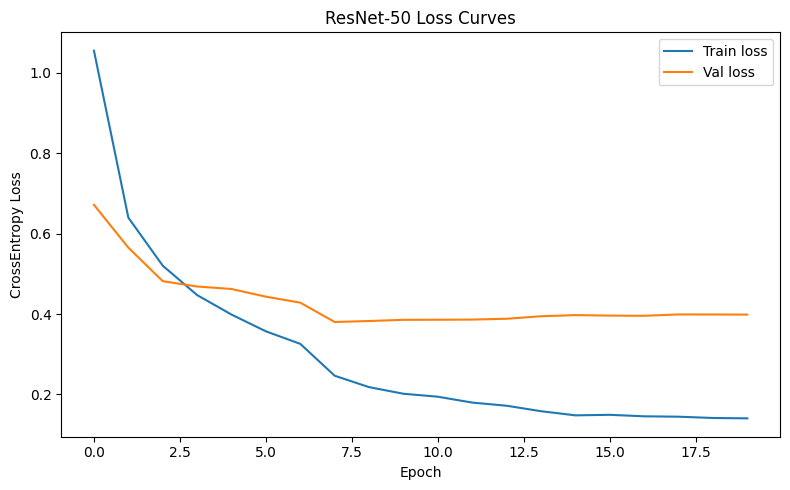

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses,   label='Val loss')
plt.xlabel('Epoch'); plt.ylabel('CrossEntropy Loss')
plt.legend(); plt.title('ResNet-50 Loss Curves')
plt.tight_layout(); plt.show()


# **2. DL-Based Object Detection (Faster R-CNN Inference)**
2.1 Pretrained Model & Classes

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
model_det = fasterrcnn_resnet50_fpn(pretrained=True).to(device).eval()
COCO_CLASSES = [
    '__background__','person','bicycle','car','motorcycle','airplane','bus',
    'train','truck','boat','traffic light','fire hydrant','stop sign','parking meter',
    # …, 'cat','dog', … up to index 90
]
TARGET_CLASSES = ['person','bicycle','car','dog','cat']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 171MB/s]


2.2 Inference & Visualization

Skipping out-of-range label 32
Skipping out-of-range label 31
Skipping out-of-range label 31
Skipping out-of-range label 27
Skipping out-of-range label 31
Skipping out-of-range label 27
Skipping out-of-range label 27
Skipping out-of-range label 27
Skipping out-of-range label 31
Skipping out-of-range label 27
Skipping out-of-range label 27
Skipping out-of-range label 32
Skipping out-of-range label 31
Skipping out-of-range label 31
Skipping out-of-range label 32


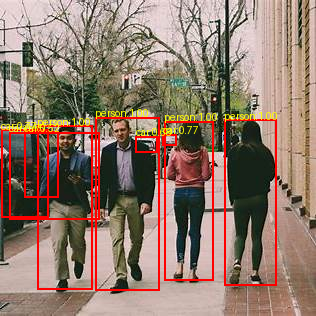

Skipping out-of-range label 51
Skipping out-of-range label 67
Skipping out-of-range label 61
Skipping out-of-range label 81


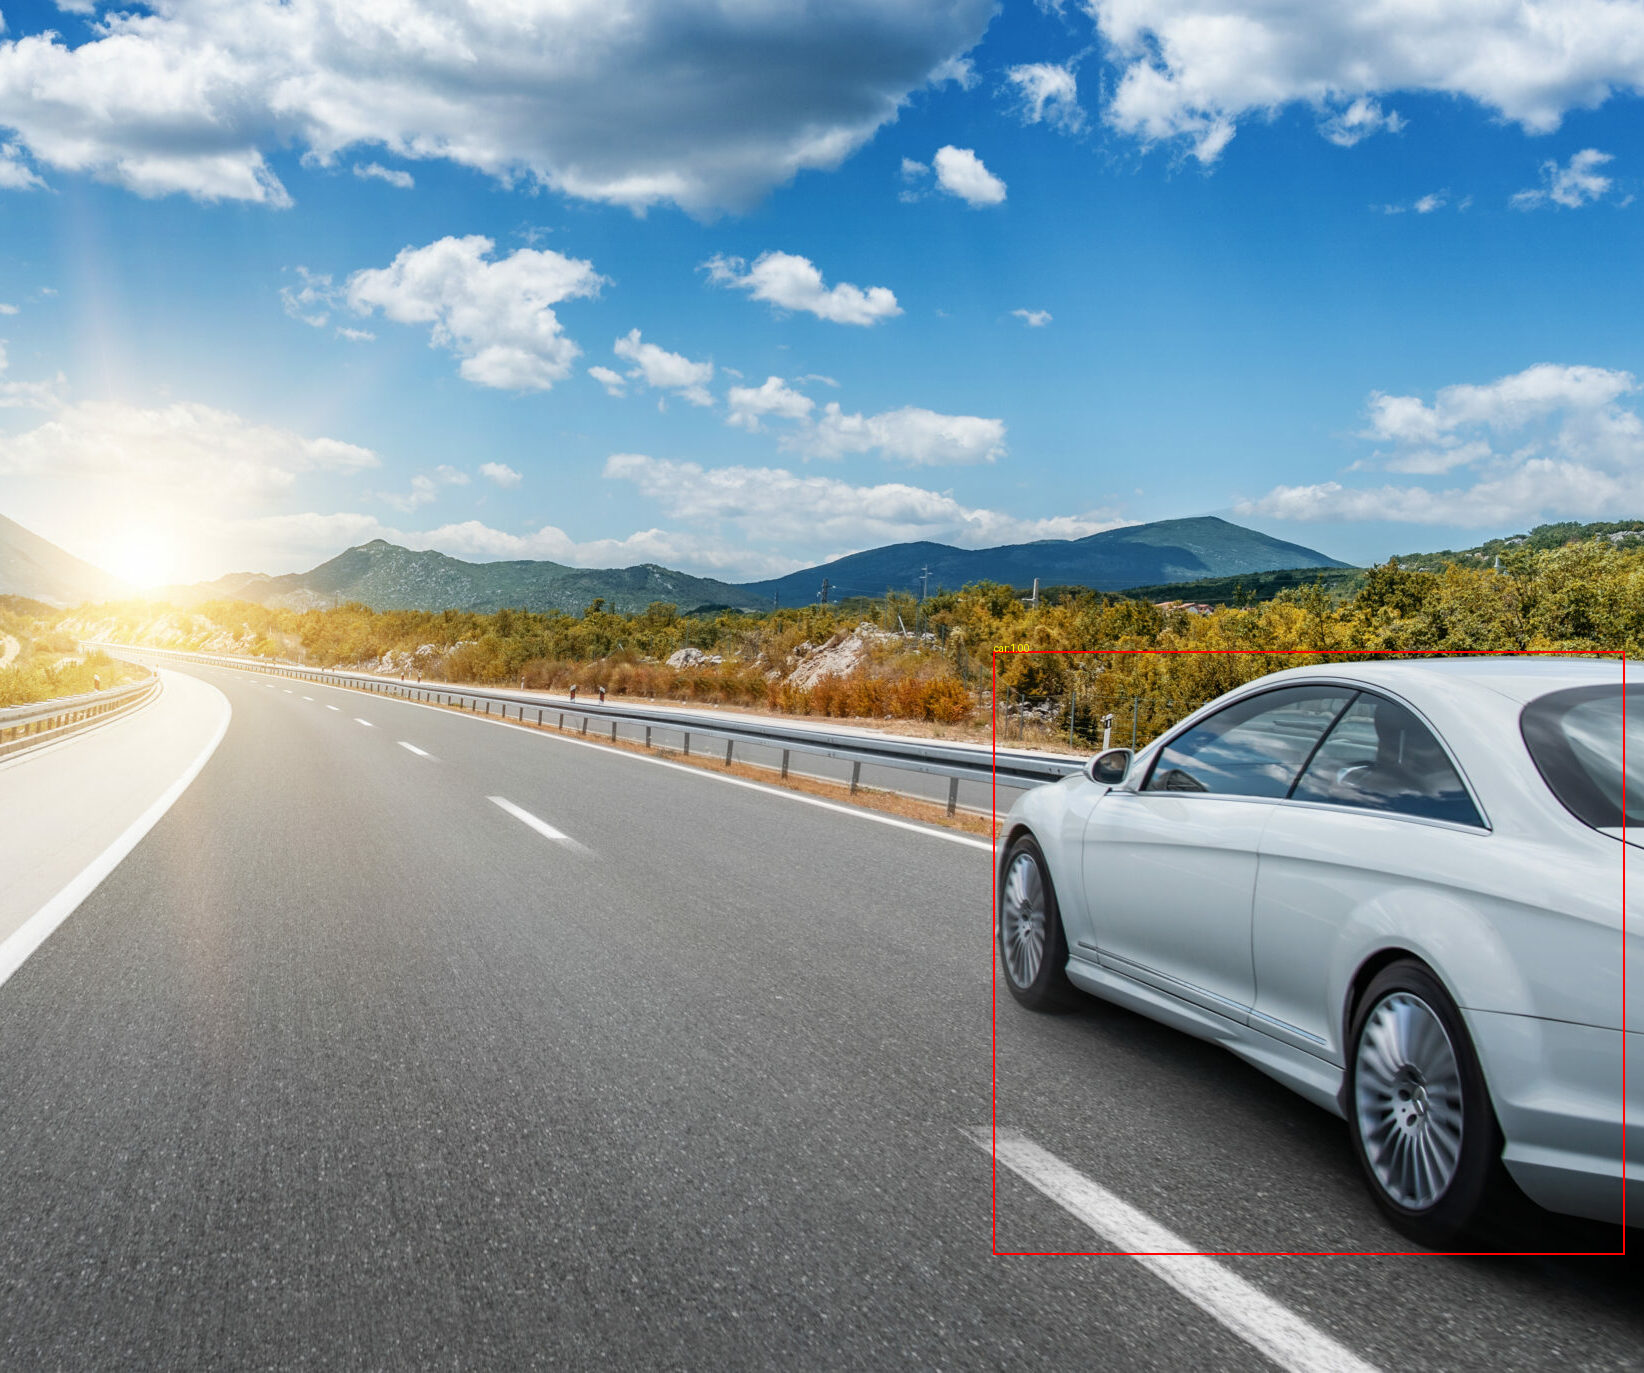

Skipping out-of-range label 43
Skipping out-of-range label 43
Skipping out-of-range label 15
Skipping out-of-range label 39


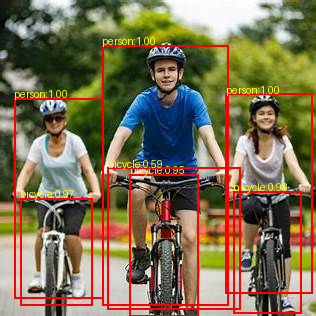

Skipping out-of-range label 18
Skipping out-of-range label 37


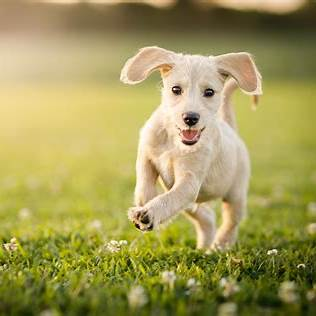

In [ ]:
import torch
from PIL import ImageDraw, Image

def detect_and_draw(img_path, threshold=0.5):
    img = Image.open(img_path).convert("RGB")
    x = transforms.ToTensor()(img).to(device)

    # turn off grads for pure inference
    with torch.no_grad():
        preds = model_det([x])[0]

    draw = ImageDraw.Draw(img)
    for box, label, score in zip(preds['boxes'], preds['labels'], preds['scores']):
        idx = int(label)  # ensure Python int
        # skip any label that isn't in your COCO_CLASSES list
        if idx < 0 or idx >= len(COCO_CLASSES):
            print(f"Skipping out-of-range label {idx}")
            continue

        cls = COCO_CLASSES[idx]
        if score > threshold and cls in TARGET_CLASSES:
            x1, y1, x2, y2 = box.detach().cpu().numpy()
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1 - 10), f"{cls}:{score:.2f}", fill="yellow")

    return img


# Run on 5 sample images (replace with your own file paths):
for path in ["img1.jpg","img2.jpg","img3.jpg","img4.jpg"]:
    result = detect_and_draw(path)
    display(result)


# **3. Vision Transformer (ViT) vs. ResNet-50**
3.1 Model & Data Preparation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from timm import create_model
import matplotlib.pyplot as plt

# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. CIFAR-10 Transforms for ViT (resize to 224×224)
transform_train_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261)),
])
transform_val_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261)),
])


3.2 Datasets & Loaders

In [ ]:

# 3.2 Datasets & Loaders
trainset_vit = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train_vit
)
valset_vit = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_val_vit
)
train_loader_vit = DataLoader(trainset_vit, batch_size=128, shuffle=True, num_workers=4)
val_loader_vit   = DataLoader(valset_vit,   batch_size=128, shuffle=False, num_workers=4)



100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


3.4. Instantiate Models


In [ ]:
#   a) ResNet-50 (fine-tuned for 10 classes, images will be center-cropped by torchvision)
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

#   b) ViT-Base Patch16 (pretrained, fine-tuned for 10 classes)
vit = create_model('vit_base_patch16_224', pretrained=True, num_classes=10)
vit = vit.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, 

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

3.5. Loss, Optimizers, Schedulers

In [ ]:
# 3.5. Loss, Optimizers, Schedulers
criterion = nn.CrossEntropyLoss()

opt_resnet = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=1e-5)
opt_vit    = optim.Adam(vit.parameters(),    lr=1e-4, weight_decay=1e-5)

sched_resnet = optim.lr_scheduler.StepLR(opt_resnet, step_size=7, gamma=0.1)
sched_vit    = optim.lr_scheduler.StepLR(opt_vit,    step_size=7, gamma=0.1)




3.6. Training & Validation Functions

In [ ]:
# 3.6. Training & Validation Functions
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def validate(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total



3.7. Main Training Loop & Metrics Storage

In [ ]:
# 3.7. Main Training Loop & Metrics Storage
epochs = 20
resnet_val_acc, vit_val_acc = [], []

for epoch in range(1, epochs+1):
    # -- ResNet
    tr_loss, tr_acc = train_one_epoch(resnet, train_loader_vit, opt_resnet)
    val_loss, val_acc = validate(resnet, val_loader_vit)
    sched_resnet.step()
    print(f"[ResNet] Epoch {epoch}/{epochs} — train_loss={tr_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
    resnet_val_acc.append(val_acc)

    # -- ViT
    tr_loss, tr_acc = train_one_epoch(vit, train_loader_vit, opt_vit)
    val_loss, val_acc = validate(vit, val_loader_vit)
    sched_vit.step()
    print(f"[ViT   ] Epoch {epoch}/{epochs} — train_loss={tr_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
    vit_val_acc.append(val_acc)



[ResNet] Epoch 1/20 — train_loss=0.2768, val_loss=0.1834, val_acc=0.9365
[ViT   ] Epoch 1/20 — train_loss=0.1574, val_loss=0.1272, val_acc=0.9589
[ResNet] Epoch 2/20 — train_loss=0.1041, val_loss=0.1447, val_acc=0.9516
[ViT   ] Epoch 2/20 — train_loss=0.0727, val_loss=0.1466, val_acc=0.9555
[ResNet] Epoch 3/20 — train_loss=0.0659, val_loss=0.1708, val_acc=0.9456
[ViT   ] Epoch 3/20 — train_loss=0.0594, val_loss=0.1433, val_acc=0.9553
[ResNet] Epoch 4/20 — train_loss=0.0511, val_loss=0.1711, val_acc=0.9479
[ViT   ] Epoch 4/20 — train_loss=0.0471, val_loss=0.1147, val_acc=0.9660
[ResNet] Epoch 5/20 — train_loss=0.0406, val_loss=0.1450, val_acc=0.9577
[ViT   ] Epoch 5/20 — train_loss=0.0422, val_loss=0.1340, val_acc=0.9610
[ResNet] Epoch 6/20 — train_loss=0.0378, val_loss=0.1801, val_acc=0.9477
[ViT   ] Epoch 6/20 — train_loss=0.0372, val_loss=0.1443, val_acc=0.9587
[ResNet] Epoch 7/20 — train_loss=0.0307, val_loss=0.1612, val_acc=0.9554
[ViT   ] Epoch 7/20 — train_loss=0.0345, val_loss=0

3.8. Plot Validation Accuracy Comparison

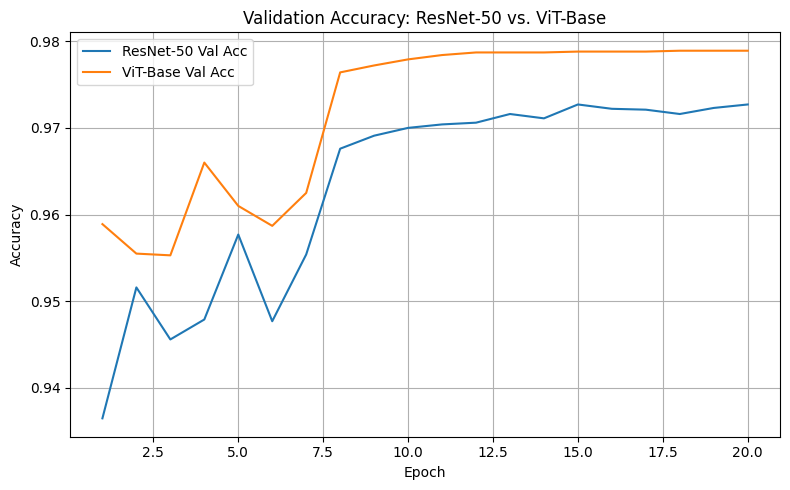

In [ ]:
# 3.8. Plot Validation Accuracy Comparison
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), resnet_val_acc, label='ResNet-50 Val Acc')
plt.plot(range(1, epochs+1), vit_val_acc,    label='ViT-Base Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Validation Accuracy: ResNet-50 vs. ViT-Base')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install -U segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# **4. Segmentation with U-Net (Lung Segmentation)**
4.1 Dataset

*   Dataset: Kaggle “Lung Segmentation” (2D CT slices + masks)

4.2 Model & Loss

In [ ]:
!pip install -q kaggle

In [ ]:
# 3. Make sure Kaggle can see it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. (Optional) Mount Google Drive to persist files
from google.colab import drive
drive.mount('/content/drive')
# e.g. data_dir = '/content/drive/MyDrive/lung_segmentation'
data_dir = '/content'

# 5. Download & unzip one of the datasets:
#    a) Finding and Measuring Lungs in CT Data
!kaggle datasets download -d kmader/finding-lungs-in-ct-data -p {data_dir} --unzip

#    b) Chest CT Segmentation
!kaggle datasets download -d polomarco/chest-ct-segmentation -p {data_dir} --unzip

#    c) COVID-19 CT Images Segmentation
!kaggle competitions download -c covid-segmentation -p {data_dir} --unzip

# 6. Inspect directory
!ls {data_dir}

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data
License(s): unknown
Dataset URL: https://www.kaggle.com/datasets/polomarco/chest-ct-segmentation
License(s): unknown
usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...
kaggle: error: unrecognized arguments: --unzip
2d_images      3d_images      images	img4.jpg	pretrained_model
2d_images.zip  3d_images.zip  img1.jpg	kaggle.json	sample_data
2d_masks       data	      img2.jpg	lung_stats.csv	train.csv
2d_masks.zip   drive	      img3.jpg	masks


In [ ]:
# 1. Install & import
!pip install -q segmentation-models-pytorch
import os, torch, numpy as np
import torch.nn as nn
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp

# 2. Dataset + Transforms
class LungSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_tf, mask_tf):
        self.img_paths  = sorted(glob(os.path.join(img_dir, "*")))
        self.mask_paths = sorted(glob(os.path.join(mask_dir,  "*")))
        assert len(self.img_paths)==len(self.mask_paths), "image/mask count mismatch"
        self.img_tf, self.mask_tf = img_tf, mask_tf

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img  = Image.open(self.img_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        return self.img_tf(img), self.mask_tf(mask)

# point to your folders
IMG_DIR  = "/content/2d_images"
MASK_DIR = "/content/2d_masks"

# force 1-channel, resize, normalize
img_tf = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])
mask_tf = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

# 3. DataLoaders
train_ds = LungSegDataset(IMG_DIR, MASK_DIR, img_tf, mask_tf)
val_ds   = LungSegDataset(IMG_DIR, MASK_DIR, img_tf, mask_tf)  # split as you wish
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)

# 4. Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
).to(device)

bce  = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode="binary")
def loss_fn(pred, target):
    return bce(pred, target) + dice_loss(pred, target)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 5. Dice coefficient metric
def dice_coeff(pred, target, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred_bin * target).sum()
    union = pred_bin.sum() + target.sum()
    return (2*inter + eps) / (union + eps)

# 6. Training & Validation
num_epochs = 10
for epoch in range(1, num_epochs+1):
    # -- train --
    model.train()
    train_losses = []
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_losses.append(loss.item())

    # -- validate --
    model.eval()
    dice_scores = []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            dice_scores.append(dice_coeff(preds, masks).item())

    print(f"Epoch {epoch:2d} | Train Loss: {np.mean(train_losses):.4f} | "
          f"Mean Dice: {np.mean(dice_scores):.4f}")


Epoch  1 | Train Loss: 1.0102 | Mean Dice: 0.8211
Epoch  2 | Train Loss: 0.6957 | Mean Dice: 0.9331
Epoch  3 | Train Loss: 0.5882 | Mean Dice: 0.9548
Epoch  4 | Train Loss: 0.5204 | Mean Dice: 0.9594
Epoch  5 | Train Loss: 0.4490 | Mean Dice: 0.9682
Epoch  6 | Train Loss: 0.3954 | Mean Dice: 0.9703
Epoch  7 | Train Loss: 0.3492 | Mean Dice: 0.9734
Epoch  8 | Train Loss: 0.3167 | Mean Dice: 0.9712
Epoch  9 | Train Loss: 0.2948 | Mean Dice: 0.9716
Epoch 10 | Train Loss: 0.2691 | Mean Dice: 0.9730


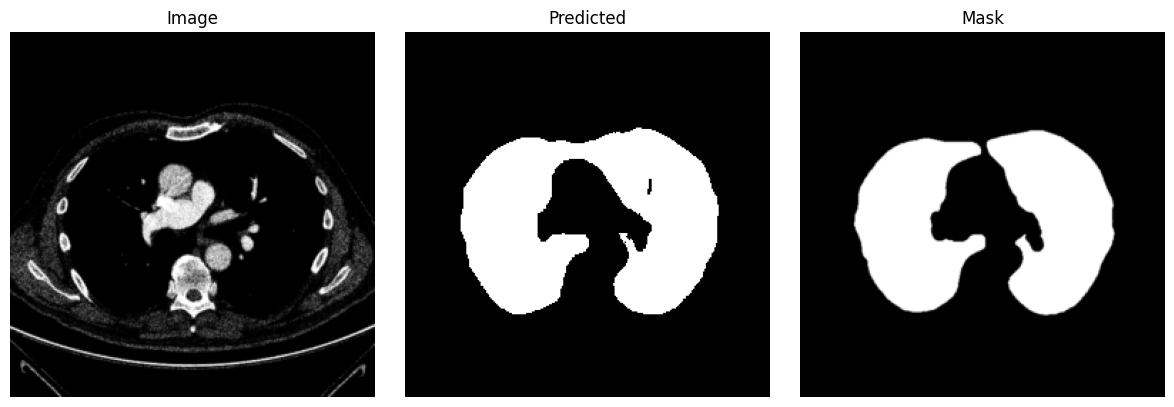

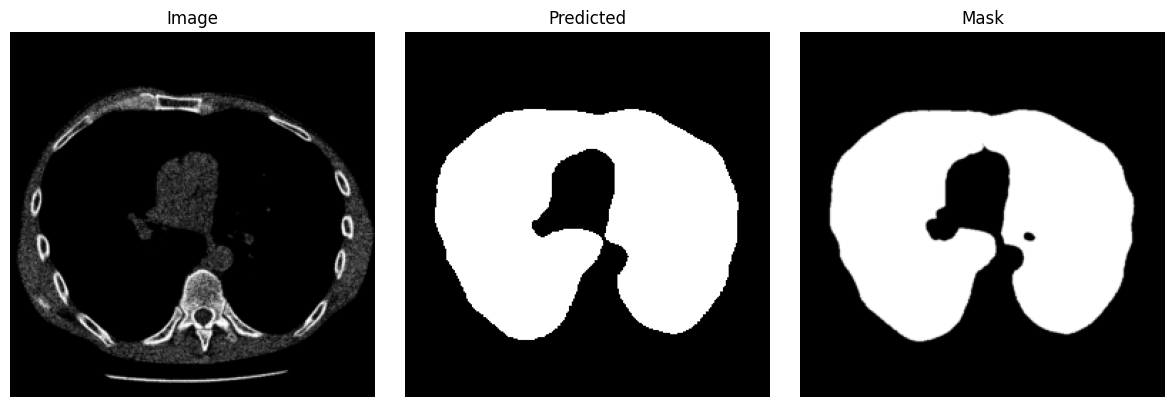

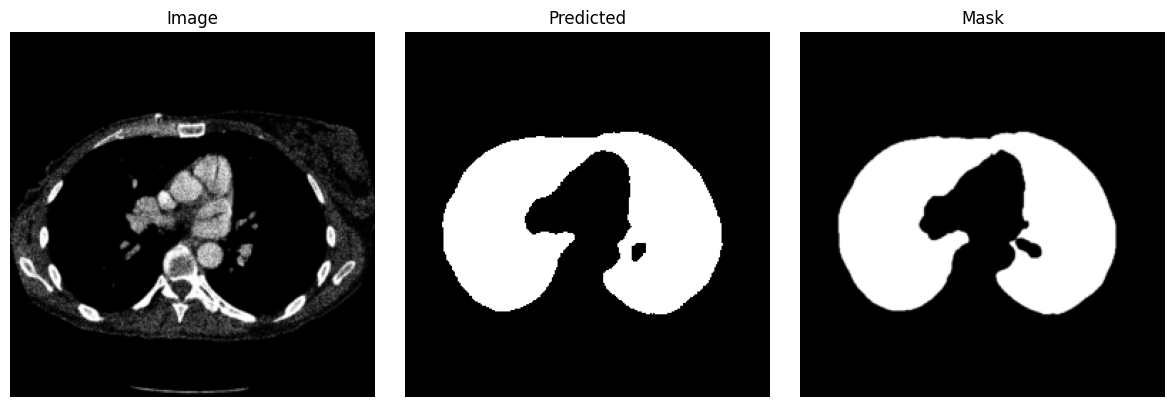

In [ ]:
import matplotlib.pyplot as plt
import torch

# get one batch
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))
    imgs, masks = imgs.to(device), masks.to(device)
    preds = model(imgs)
    # binarize predictions
    preds_bin = (torch.sigmoid(preds) > 0.5).float()

# move back to CPU for plotting
imgs_cpu   = imgs.cpu().numpy()
masks_cpu  = masks.cpu().numpy()
preds_cpu  = preds_bin.cpu().numpy()

# plot first 3 samples
for i in range(3):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    # Original CT slice
    axes[0].imshow(imgs_cpu[i].squeeze(), cmap='gray')
    axes[0].set_title('Image')
    # Predicted mask
    axes[1].imshow(preds_cpu[i].squeeze(), cmap='gray')
    axes[1].set_title('Predicted')
    # Ground-truth mask
    axes[2].imshow(masks_cpu[i].squeeze(), cmap='gray')
    axes[2].set_title('Mask')

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# **5. GAN (DCGAN on MNIST)**
5.1 Architecture (Generator & Discriminator)

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 48.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.21MB/s]

Starting Training Loop...


[1/25][0/469] Loss_D: 1.3107 Loss_G: 2.0463 D(x): 0.6942 D(G(z)): 0.5777 / 0.1481
[1/25][100/469] Loss_D: 0.1775 Loss_G: 4.0925 D(x): 0.9179 D(G(z)): 0.0791 / 0.0229
[1/25][200/469] Loss_D: 0.2441 Loss_G: 3.9647 D(x): 0.9127 D(G(z)): 0.1283 / 0.0270
[1/25][300/469] Loss_D: 0.1829 Loss_G: 2.9082 D(x): 0.9338 D(G(z)): 0.1033 / 0.0681
[1/25][400/469] Loss_D: 0.1153 Loss_G: 3.6140 D(x): 0.9734 D(G(z)): 0.0822 / 0.0346
[2/25][0/469] Loss_D: 0.5916 Loss_G: 2.0929 D(x): 0.6552 D(G(z)): 0.0991 / 0.1590
[2/25][100/469] Loss_D: 0.5312 Loss_G: 1.7751 D(x): 0.7825 D(G(z)): 0.2160 / 0.1995
[2/25][200/469] Loss_D: 0.4941 Loss_G: 2.5044 D(x): 0.8584 D(G(z)): 0.2687 / 0.0999
[2/25][300/469] Loss_D: 0.5401 Loss_G: 1.4692 D(x): 0.7273 D(G(z)): 0.1695 / 0.2665
[2/25][400/469] Loss_D: 2.1731 Loss_G: 0.3406 D(x): 0.1732 D(G(z)): 0.0079 / 0.7357
[3/25][0/469] Loss_D: 1.0059 Loss_G: 0.2150 D(x): 0.5166 D(G(z)): 0.1847 / 0.8208
[3/25][100/469] Loss_D: 0.9446 Loss_G: 1.5898 D(x): 0.7892 D(G(z)): 0.4298 / 0.247

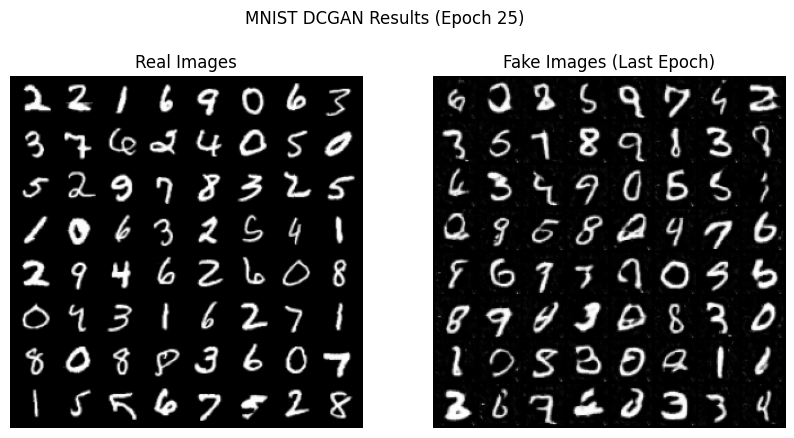

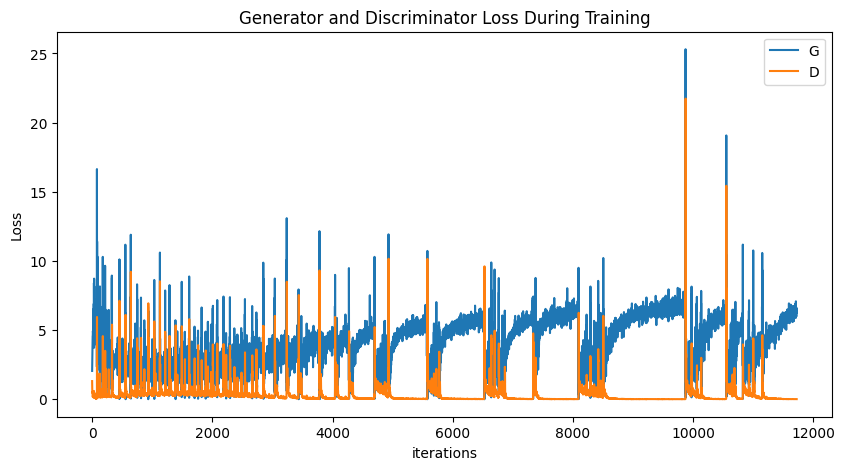


--- Generating 5 New Samples ---


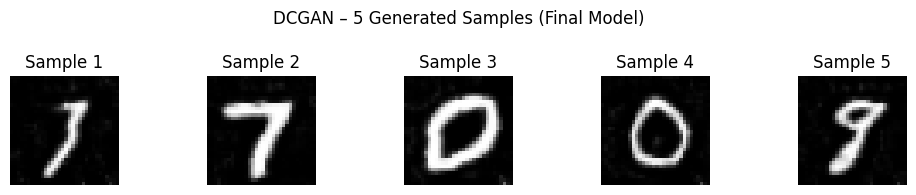

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os # Optional: for saving results

# --- Hyperparameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

lr = 2e-4
beta1 = 0.5 # Recommended beta1 for Adam in DCGAN paper
batch_size = 128
image_size = 32 # Resize MNIST images to 32x32
img_channels = 1 # MNIST is grayscale
nz = 100  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
num_epochs = 50 # Reduced for quicker demonstration (50 is fine too)

# --- Data Loading and Preprocessing ---
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), # Normalize to [-1, 1]
])

# Download and load the MNIST dataset
# Use download=True only the first time
try:
    mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
except RuntimeError:
    print("Trying download again with different mirror...")
    MNIST_URL = 'https://ossci-datasets.s3.amazonaws.com/mnist' # Alternative URL
    torchvision.datasets.MNIST.resources = [
            ('/'.join([MNIST_URL, 'train-images-idx3-ubyte.gz']), 'f68b3c2ef7300657011e3f13469f9f72'),
            ('/'.join([MNIST_URL, 'train-labels-idx1-ubyte.gz']), 'd53e105ee54ea40749a09fcbcd1e9432'),
            ('/'.join([MNIST_URL, 't10k-images-idx3-ubyte.gz']), '9fb629c4189551a2d022fa330f9573f3'),
            ('/'.join([MNIST_URL, 't10k-labels-idx1-ubyte.gz']), 'ec29112dd5afa0611ce80d1b7f02629c')
        ]
    mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)


# Create the dataloader
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# --- Weight Initialization ---
# Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# --- 5.1 Architecture (Generator & Discriminator) ---

# Generator Code
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, img_channels=1):
        super().__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # state size. nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (img_channels) x 32 x 32
        )
    def forward(self, input):
        return self.main(input)

# Discriminator Code
class Discriminator(nn.Module):
    def __init__(self, ndf=64, img_channels=1):
        super().__init__()
        self.main = nn.Sequential(
            # input is (img_channels) x 32 x 32
            nn.Conv2d(img_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. 1 x 1 x 1
        )
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1) # Flatten output



5.2 Training Loop (Outline)

In [ ]:
# --- 5.2 Training Loop (Outline) ---

# Create the generator and discriminator
netG = Generator(nz, ngf, img_channels).to(device)
netD = Discriminator(ndf, img_channels).to(device)

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)
netD.apply(weights_init)

# Print the models
# print(netG)
# print(netD)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# Lists to keep track of progress
G_losses = []
D_losses = []
img_list = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (real_imgs, _) in enumerate(mnist_loader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = real_imgs.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu) # Removed .view(-1) -> handled in forward
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item() # Average D output for real images

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()) # detach() stops gradients flowing to G
         # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item() # Average D output for fake images (before G update)
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake) # Don't detach fake here, we need gradients for G
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item() # Average D output for fake images (after G update)
        # Update G
        optG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Output training stats
        if i % 100 == 0:
             print(f'[{epoch+1}/{num_epochs}][{i}/{len(mnist_loader)}] '
                   f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                   f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(mnist_loader)-1)):
            with torch.no_grad():
                fake_display = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake_display, padding=2, normalize=True))

        iters += 1



5.3 Generate & Display 5 Samples

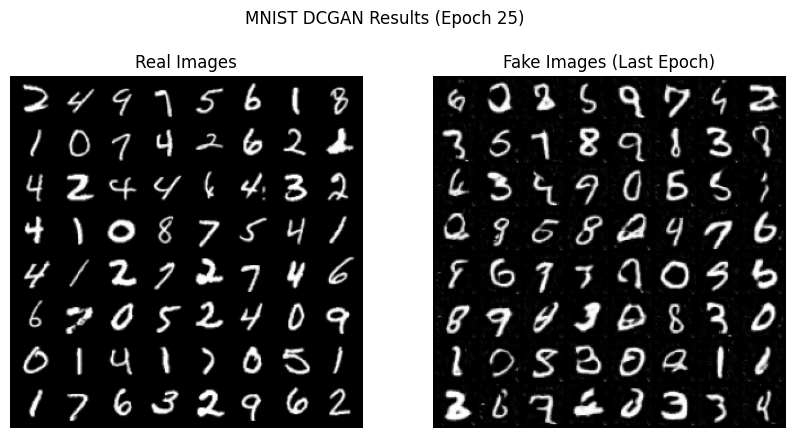

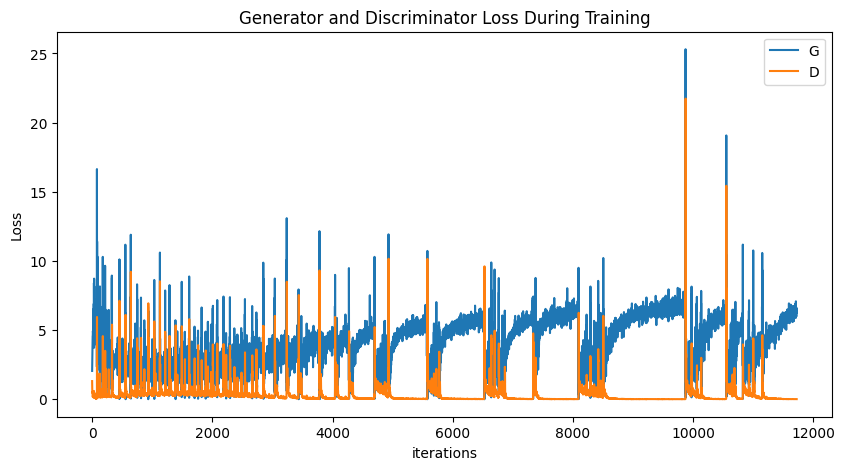

In [ ]:
# --- 5.3 Generate & Display 5 Samples ---

# Grab a batch of real images from the dataloader
real_batch = next(iter(mnist_loader))

# Plot the real images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images (Last Epoch)")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.suptitle(f'MNIST DCGAN Results (Epoch {num_epochs})')
plt.show()

# Plot Training Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()




5.4 Generate and display 5 individual samples


--- Generating 5 New Samples ---


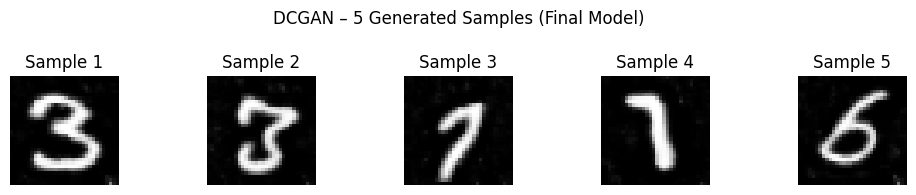

In [ ]:
# Generate and display 5 individual samples
print("\n--- Generating 5 New Samples ---")
netG.eval() # Set generator to evaluation mode
num_samples_to_show = 5
with torch.no_grad():
    # Generate noise
    noise = torch.randn(num_samples_to_show, nz, 1, 1, device=device)
    # Generate fake images
    fake = netG(noise).cpu() # Generate and move to CPU

# Post-process and display
fig, axes = plt.subplots(1, num_samples_to_show, figsize=(10, 2))
# Squeeze removes the channel dimension (1) if it's there
processed_fake = fake.squeeze().numpy()

# If only one image was generated, numpy array might not have the batch dimension
if num_samples_to_show == 1:
    processed_fake = [processed_fake] # Make it iterable

for i, (ax, img) in enumerate(zip(axes, processed_fake)):
    # De-normalize from [-1, 1] to [0, 1]
    img_display = (img + 1) / 2
    ax.imshow(img_display, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Sample {i+1}')

plt.suptitle(f'DCGAN – {num_samples_to_show} Generated Samples (Final Model)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()